# procedure of Score-CAM

1. upsample the output of final conv layer to original input size
2. normalize the raw activation value in each activation map into [0, 1]
3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
4. feed masked inputs into CNN model and softmax
5. define weight as the score of target class
6. get final class discriminative localization map as linear weighted combination of all activation maps

# implementation of Score-CAM with keras

- returns: 2d numpy array scaled into [0., 1.]

In [20]:
import cv2
import numpy as np
from keras.models import Model

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

# Score-CAM with VGG16

### original image

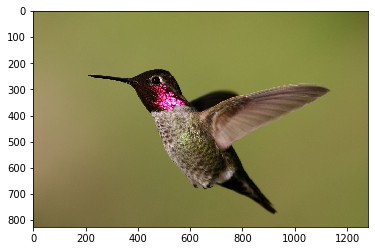

In [21]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

orig_img = np.array(load_img('./image/hummingbird.jpg'),dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

### heatmap

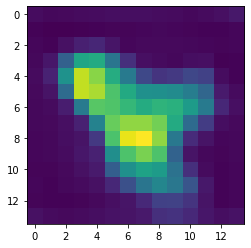

In [22]:
from keras.applications.vgg16 import VGG16
from gradcamutils import read_and_preprocess_img
import matplotlib.pyplot as plt

model = VGG16(include_top=True, weights='imagenet')
layer_name = 'block5_conv3'
img_array = read_and_preprocess_img('./image/hummingbird.jpg', size=(224,224))

score_cam = ScoreCam(model,img_array,layer_name)

plt.imshow(score_cam)
plt.show()

# conpare Grad-CAM, Grad-CAM++, Score-CAM, Faster-Score-CAM

./image/hummingbird.jpg
class activation map for: ('n01833805', 'hummingbird', 0.99999976)


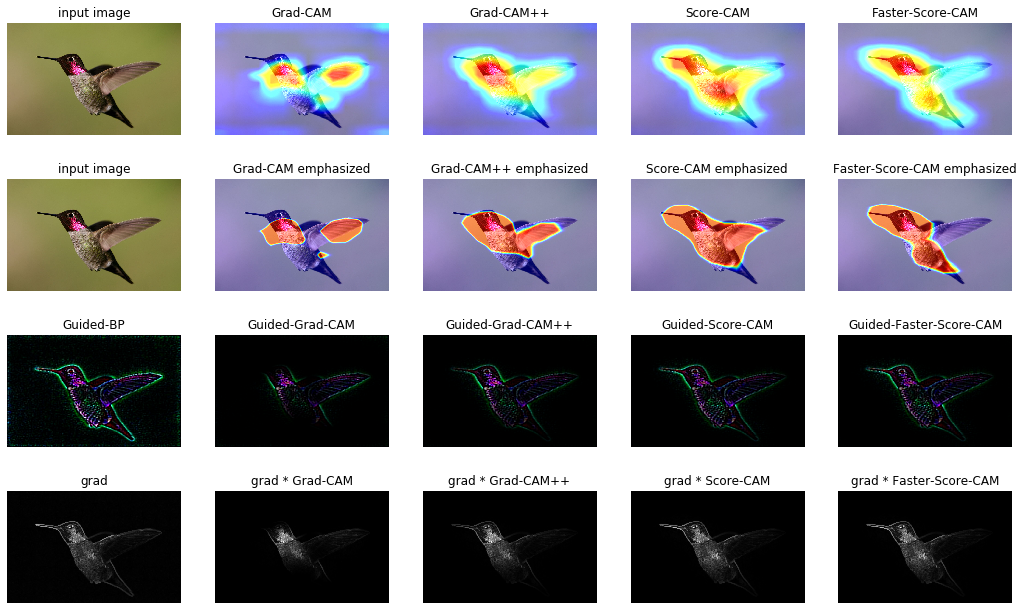

In [18]:
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import cv2
import numpy as np
from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

def build_VGG16():
    return VGG16(include_top=True, weights='imagenet')

model = build_VGG16()
layer_name = 'block5_conv3'

img_path = './image/hummingbird.jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

predictions = model.predict(img_array)
top = decode_predictions(predictions, top=5)[0]
print(img_path)
print("class activation map for:",top[0])

grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

guided_model = build_guided_model(build_VGG16)
saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  # 画像の勾配を取得
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  # 太らせる処理
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized
grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 11))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
ax[0,3].imshow(score_cam_superimposed)
ax[0,3].set_title("Score-CAM")
ax[0,4].imshow(faster_score_cam_superimposed)
ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
ax[1,3].imshow(score_cam_emphasized)
ax[1,3].set_title("Score-CAM emphasized")
ax[1,4].imshow(faster_score_cam_emphasized)
ax[1,4].set_title("Faster-Score-CAM emphasized")
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
ax[2,3].imshow(guided_score_cam)
ax[2,3].set_title("Guided-Score-CAM")
ax[2,4].imshow(guided_faster_score_cam)
ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
ax[3,3].imshow(grad_times_score_cam, 'gray')
ax[3,3].set_title("grad * Score-CAM")
ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
ax[3,4].set_title("grad * Faster-Score-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()

# processing time

In [7]:
print("Grad-CAM")
%timeit grad_cam = GradCam(model, img_array, layer_name)
print("Grad-CAM++")
%timeit grad_cam_plus_plus = GradCamPlusPlus(model, img_array, layer_name)
print("Score-Cam")
%timeit score_cam = ScoreCam(model, img_array, layer_name)
print("Faster-Score-Cam N=10")
%timeit faster_score_cam = ScoreCam(model, img_array, layer_name, max_N=10)
print("Faster-Score-Cam N=3")
%timeit faster_score_cam = ScoreCam(model, img_array, layer_name, max_N=3)
print("Guided-BP}")
%timeit saliency = GuidedBackPropagation(guided_model, img_array, layer_name)

Grad-CAM
189 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Grad-CAM++
236 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Score-Cam
2.46 s ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Faster-Score-Cam N=10
253 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Faster-Score-Cam N=3
221 ms ± 4.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Guided-BP}
397 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# visualization for other images

./image/cat_dog.png
class activation map for: ('n02108089', 'boxer', 0.42014146)


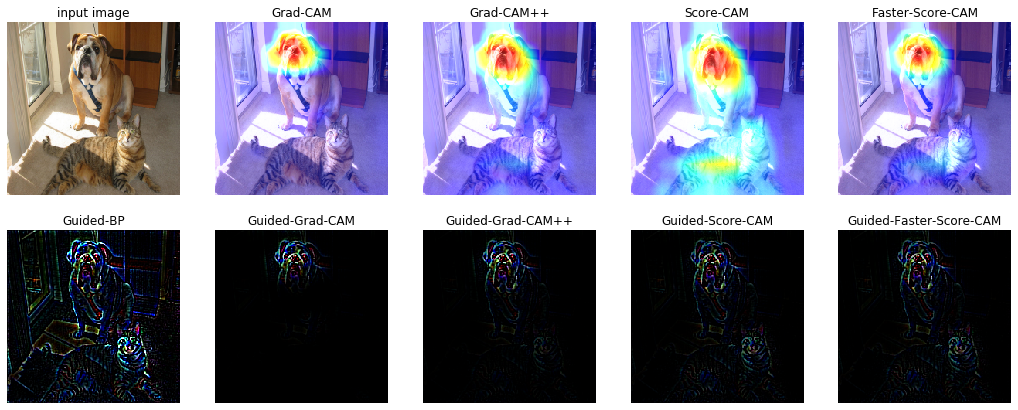

./image/collies.JPG
class activation map for: ('n02106166', 'Border_collie', 0.67478716)


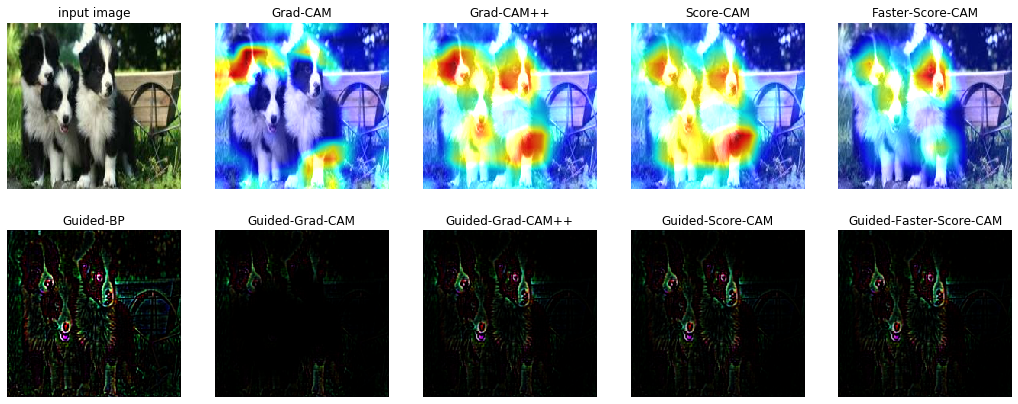

./image/water-bird.JPEG
class activation map for: ('n02006656', 'spoonbill', 0.9999374)


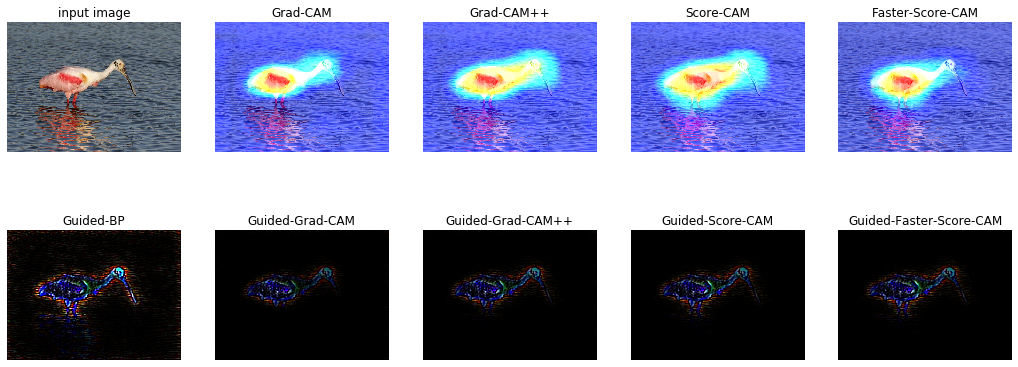

In [19]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

model = build_VGG16()
img_basenames = ["cat_dog.png","collies.JPG","water-bird.JPEG"]

for basename in img_basenames:
    img_path = f'./image/{basename}'
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = read_and_preprocess_img(img_path, size=(224,224))

    predictions = model.predict(img_array)
    top = decode_predictions(predictions, top=5)[0]

    grad_cam=GradCam(model,img_array,layer_name)
    grad_cam_superimposed = superimpose(img_path, grad_cam)

    grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
    grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)

    score_cam=ScoreCam(model,img_array,layer_name)
    score_cam_superimposed = superimpose(img_path, score_cam)

    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)

    guided_model = build_guided_model(build_VGG16)
    saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
    saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

    grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
    guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

    grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
    guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

    score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
    guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

    faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
    guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

    print(img_path)
    print("class activation map for:",top[0])
    fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(18, 7))
    ax[0,0].imshow(orig_img)
    ax[0,0].set_title("input image")
    ax[0,1].imshow(grad_cam_superimposed)
    ax[0,1].set_title("Grad-CAM")
    ax[0,2].imshow(grad_cam_plus_plus_superimposed)
    ax[0,2].set_title("Grad-CAM++")
    ax[0,3].imshow(score_cam_superimposed)
    ax[0,3].set_title("Score-CAM")
    ax[0,4].imshow(faster_score_cam_superimposed)
    ax[0,4].set_title("Faster-Score-CAM")
    ax[1,0].imshow(saliency_resized)
    ax[1,0].set_title("Guided-BP")
    ax[1,1].imshow(guided_grad_cam)
    ax[1,1].set_title("Guided-Grad-CAM")
    ax[1,2].imshow(guided_grad_cam_plus_plus)
    ax[1,2].set_title("Guided-Grad-CAM++")
    ax[1,3].imshow(guided_score_cam)
    ax[1,3].set_title("Guided-Score-CAM")
    ax[1,4].imshow(guided_faster_score_cam)
    ax[1,4].set_title("Guided-Faster-Score-CAM")
    for i in range(2):
        for j in range(5):
            ax[i,j].axis('off')
    plt.savefig(f"result/result_{top[0][1]}")
    plt.show()

# Sample code for applying Score-CAM to your model

## [DAGM dataset](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html)

Please rewrite `dagm_path` after download and unzip [DAGM dataset](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html).

In [23]:
from keras.utils import to_categorical
import numpy as np  
import glob
from sklearn.model_selection import train_test_split  
from gradcamutils import read_and_preprocess_img

num_classes = 2                               
img_size = (224,224)
dagm_path = "/DAGM"

def get_dagm_data(names):
    x = []
    y = []
    for i, name in enumerate(names):
        for path in glob.glob(f"{dagm_path}/{name}/*.png"):    
            img_array = read_and_preprocess_img(path, size=img_size)
            x.append(img_array)  
            y.append(i) 

    x = np.concatenate(x, axis=0)   
    y = np.array(y)  

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=111)

    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_dagm_data(["Class1","Class1_def"])

920 train samples
230 test samples


# ResNet

In [24]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

def build_ResNet():
    model = ResNet50(include_top=True, input_tensor=Input(shape=(img_size[0],img_size[1],3)))

    x = model.layers[-98].output
    x = Activation('relu', name="act_last")(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, name="dense_out")(x)
    outputs = Activation('softmax')(x)

    model = Model(model.input, outputs)
    # model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(amsgrad=True),
                  metrics=['accuracy'])
    return model

model = build_ResNet()

es_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')
chkpt = './resnet_weight_DAGM.h5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

epochs = 30
batch_size = 32

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[es_cb,cp_cb],
                    class_weight={0: 1., 1: 6.},
                    shuffle=True)

model.load_weights('./resnet_weight_DAGM.h5')

Train on 920 samples, validate on 230 samples
Epoch 1/30
920/920 [==============================] - 14s 15ms/step - loss: 0.3833 - acc: 0.9326 - val_loss: 7.9952 - val_acc: 0.1391

Epoch 00001: val_loss improved from inf to 7.99518, saving model to ./resnet_weight_DAGM.h5
Epoch 2/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0693 - acc: 0.9935 - val_loss: 13.8915 - val_acc: 0.1304

Epoch 00002: val_loss did not improve from 7.99518
Epoch 3/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0185 - acc: 0.9967 - val_loss: 0.0453 - val_acc: 0.9957

Epoch 00003: val_loss improved from 7.99518 to 0.04533, saving model to ./resnet_weight_DAGM.h5
Epoch 4/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0675 - acc: 0.9957 - val_loss: 7.2489 - val_acc: 0.2000

Epoch 00004: val_loss did not improve from 0.04533
Epoch 5/30
920/920 [==============================] - 7s 8ms/step - loss: 0.1030 - acc: 0.9870 - val_loss: 0.0075 - val_acc: 1.00

### attention

When you use Guided-Backpropagation for your own model, you need to rewrite `build_model_function`.

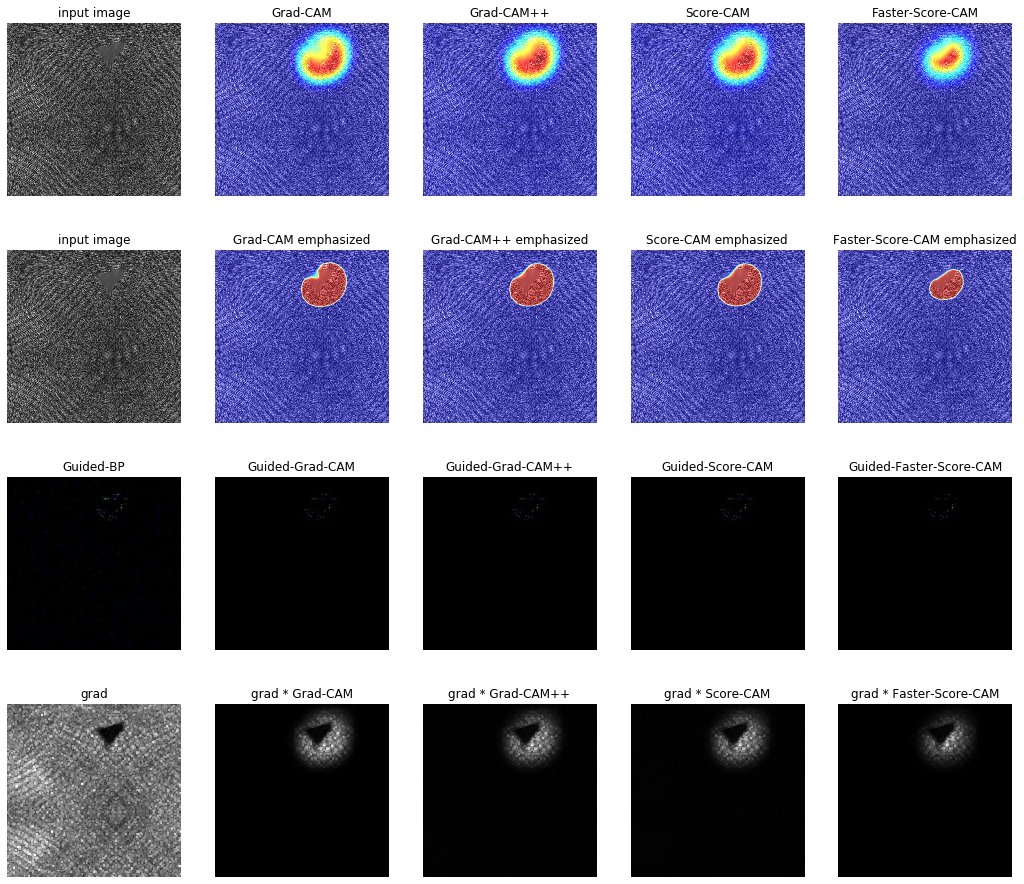

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, GuidedBackPropagation, superimpose, read_and_preprocess_img

def build_ResNet_and_load():
    model = build_ResNet()
    model.load_weights('./resnet_weight_DAGM.h5')
    return model

img_path = f'{dagm_path}/Class1_def/12.png'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

layer_name = "act_last"

grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

guided_model = build_guided_model(build_ResNet_and_load)
saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

faster_score_cam_resized = cv2.resize(faster_score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized
grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 16))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
ax[0,3].imshow(score_cam_superimposed)
ax[0,3].set_title("Score-CAM")
ax[0,4].imshow(faster_score_cam_superimposed)
ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
ax[1,3].imshow(score_cam_emphasized)
ax[1,3].set_title("Score-CAM emphasized")
ax[1,4].imshow(faster_score_cam_emphasized)
ax[1,4].set_title("Faster-Score-CAM emphasized")
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
ax[2,3].imshow(guided_score_cam)
ax[2,3].set_title("Guided-Score-CAM")
ax[2,4].imshow(guided_faster_score_cam)
ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
ax[3,3].imshow(grad_times_score_cam, 'gray')
ax[3,3].set_title("grad * Score-CAM")
ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
ax[3,4].set_title("grad * Faster-Score-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()

## DAGM Class1

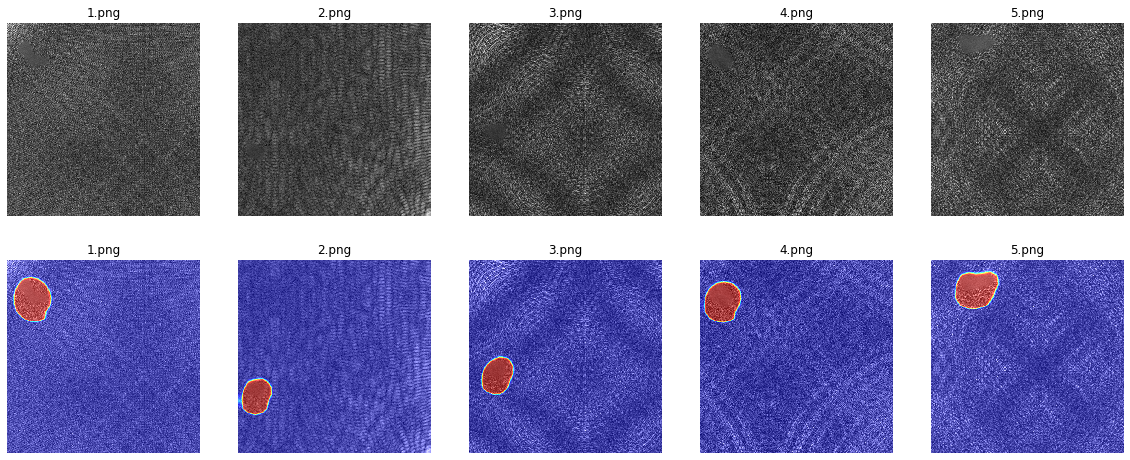

<Figure size 1440x576 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from gradcamutils import ScoreCam, superimpose, read_and_preprocess_img

layer_name = "act_last"

fig = plt.figure(figsize=(20, 8))
for i, img_path in enumerate(glob.glob(f"{dagm_path}/Class1_def/*.png")[:5]):
    
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = read_and_preprocess_img(img_path, size=(224,224))
    
    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    
    ax = fig.add_subplot(2, 5, i%5 + 1)
    ax.imshow(orig_img)
    ax.set_title(f"{i+1}.png")
    ax.axis('off')
    
    ax = fig.add_subplot(2, 5, 5 + i%5 + 1)
    ax.imshow(faster_score_cam_emphasized)
    ax.set_title(f"{i+1}.png")
    ax.axis('off')
    
    if (i+1)%5 == 0:
        plt.savefig(f"./result/Class1_result_{i//5}.png")
        plt.show()
        fig = plt.figure(figsize=(20, 8))

# DAGM Class2 - Class6

Class2===============================================================
920 train samples
230 test samples
Train on 920 samples, validate on 230 samples
Epoch 1/30
920/920 [==============================] - 15s 17ms/step - loss: 1.5974 - acc: 0.5913 - val_loss: 0.5951 - val_acc: 0.6609

Epoch 00001: val_loss improved from inf to 0.59515, saving model to ./resnet_weight_DAGM_Class2.h5
Epoch 2/30
920/920 [==============================] - 7s 8ms/step - loss: 1.2273 - acc: 0.5261 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00002: val_loss did not improve from 0.59515
Epoch 3/30
920/920 [==============================] - 7s 8ms/step - loss: 0.5503 - acc: 0.8967 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00003: val_loss did not improve from 0.59515
Epoch 4/30
920/920 [==============================] - 7s 8ms/step - loss: 0.2754 - acc: 0.9674 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00004: val_loss did not improve from 0.59515
Epoch 5/30
920/920 [==============================] - 7s 8ms

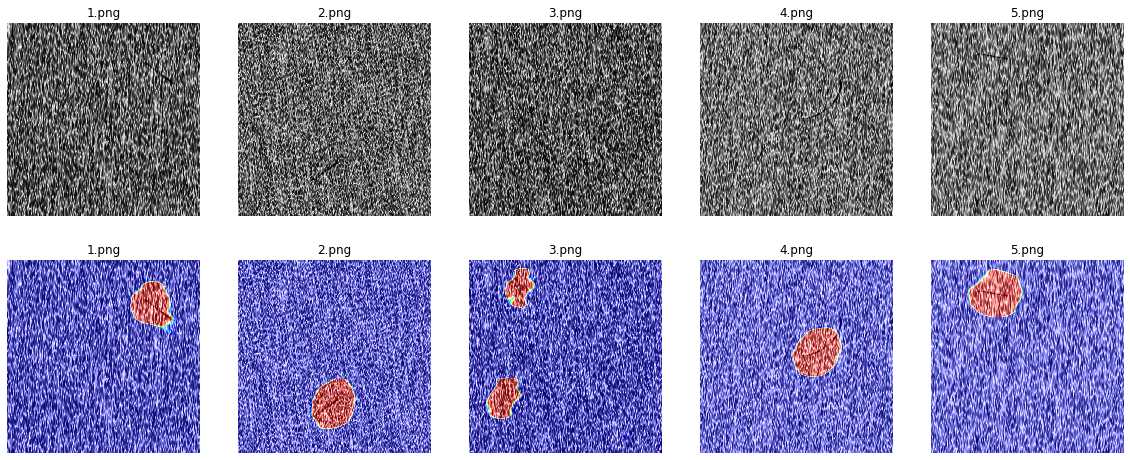

Class3===============================================================
920 train samples
230 test samples
Train on 920 samples, validate on 230 samples
Epoch 1/30
920/920 [==============================] - 16s 18ms/step - loss: 0.8797 - acc: 0.7098 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00001: val_loss improved from inf to 13.93934, saving model to ./resnet_weight_DAGM_Class3.h5
Epoch 2/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0694 - acc: 0.9946 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00002: val_loss did not improve from 13.93934
Epoch 3/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0215 - acc: 1.0000 - val_loss: 13.9219 - val_acc: 0.1304

Epoch 00003: val_loss improved from 13.93934 to 13.92186, saving model to ./resnet_weight_DAGM_Class3.h5
Epoch 4/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0250 - acc: 0.9978 - val_loss: 0.0485 - val_acc: 0.9957

Epoch 00004: val_loss improved from 13.92186 to 0.04853

<Figure size 1440x576 with 0 Axes>

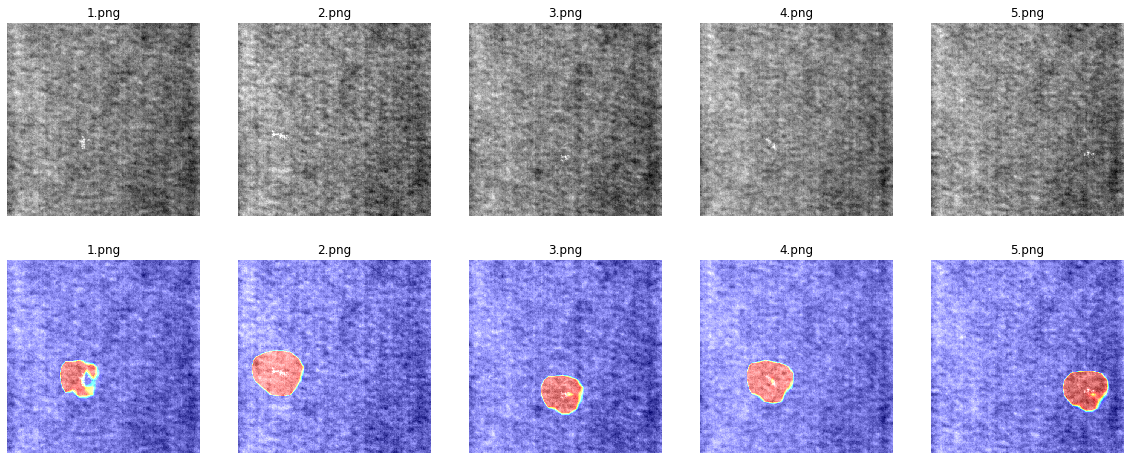

Class4===============================================================
920 train samples
230 test samples
Train on 920 samples, validate on 230 samples
Epoch 1/30
920/920 [==============================] - 18s 20ms/step - loss: 0.9945 - acc: 0.7163 - val_loss: 6.5236 - val_acc: 0.1304

Epoch 00001: val_loss improved from inf to 6.52363, saving model to ./resnet_weight_DAGM_Class4.h5
Epoch 2/30
920/920 [==============================] - 7s 8ms/step - loss: 0.1176 - acc: 0.9935 - val_loss: 0.9009 - val_acc: 0.7261

Epoch 00002: val_loss improved from 6.52363 to 0.90090, saving model to ./resnet_weight_DAGM_Class4.h5
Epoch 3/30
920/920 [==============================] - 7s 8ms/step - loss: 0.1467 - acc: 0.9772 - val_loss: 3.3701 - val_acc: 0.1304

Epoch 00003: val_loss did not improve from 0.90090
Epoch 4/30
920/920 [==============================] - 7s 8ms/step - loss: 0.1761 - acc: 0.9630 - val_loss: 13.0781 - val_acc: 0.1304

Epoch 00004: val_loss did not improve from 0.90090
Epoch 5/30

<Figure size 1440x576 with 0 Axes>

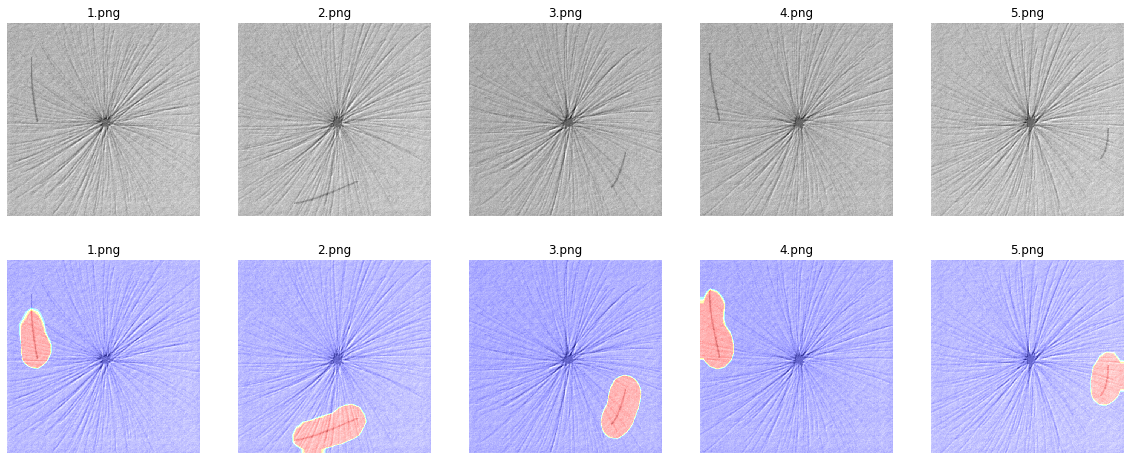

Class5===============================================================
920 train samples
230 test samples
Train on 920 samples, validate on 230 samples
Epoch 1/30
920/920 [==============================] - 19s 21ms/step - loss: 1.3063 - acc: 0.5772 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00001: val_loss improved from inf to 13.93934, saving model to ./resnet_weight_DAGM_Class5.h5
Epoch 2/30
920/920 [==============================] - 7s 8ms/step - loss: 0.5913 - acc: 0.9109 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00002: val_loss did not improve from 13.93934
Epoch 3/30
920/920 [==============================] - 7s 8ms/step - loss: 0.2931 - acc: 0.9543 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00003: val_loss did not improve from 13.93934
Epoch 4/30
920/920 [==============================] - 7s 8ms/step - loss: 0.1361 - acc: 0.9826 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00004: val_loss did not improve from 13.93934
Epoch 5/30
920/920 [==============================] - 7

<Figure size 1440x576 with 0 Axes>

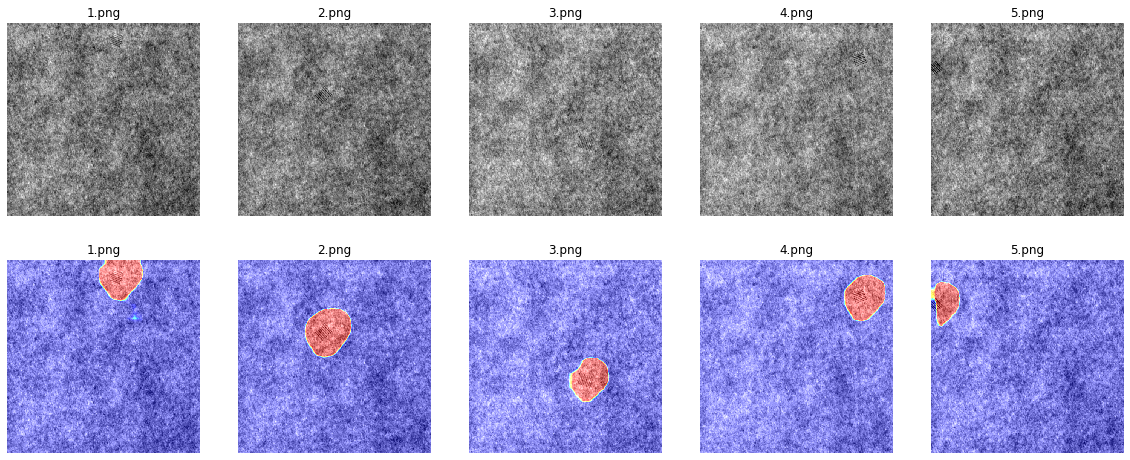

Class6===============================================================
920 train samples
230 test samples
Train on 920 samples, validate on 230 samples
Epoch 1/30
920/920 [==============================] - 20s 22ms/step - loss: 0.2282 - acc: 0.9413 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00001: val_loss improved from inf to 13.93934, saving model to ./resnet_weight_DAGM_Class6.h5
Epoch 2/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0230 - acc: 0.9946 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00002: val_loss did not improve from 13.93934
Epoch 3/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0189 - acc: 0.9967 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00003: val_loss did not improve from 13.93934
Epoch 4/30
920/920 [==============================] - 7s 8ms/step - loss: 0.0074 - acc: 0.9989 - val_loss: 13.9393 - val_acc: 0.1304

Epoch 00004: val_loss did not improve from 13.93934
Epoch 5/30
920/920 [==============================] - 7

<Figure size 1440x576 with 0 Axes>

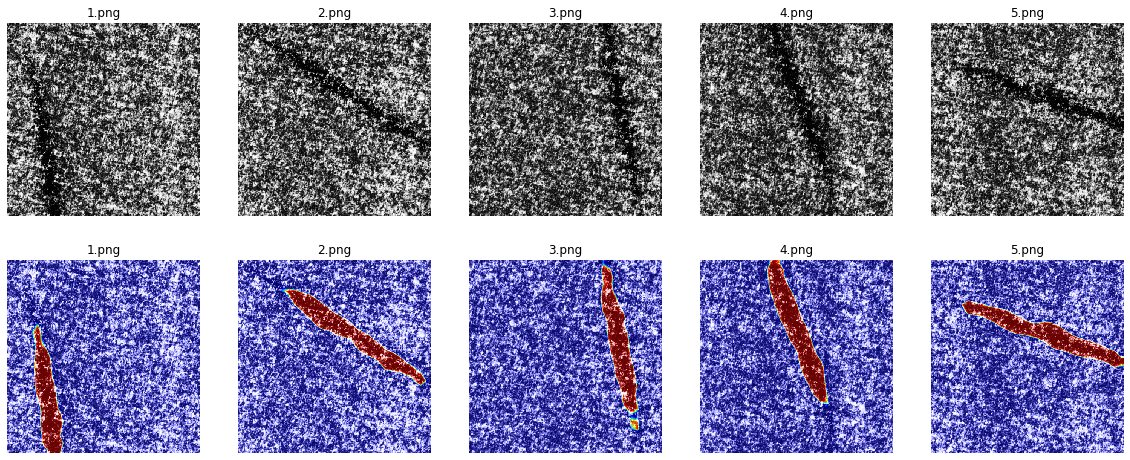

<Figure size 1440x576 with 0 Axes>

In [26]:
from keras.utils import to_categorical
import numpy as np  
import glob
from sklearn.model_selection import train_test_split  
from gradcamutils import read_and_preprocess_img

for names in [["Class2", "Class2_def"], ["Class3", "Class3_def"], ["Class4", "Class4_def"], ["Class5", "Class5_def"], ["Class6", "Class6_def"], ]:
    print(f"{names[0]}===============================================================")
    
    x_train, x_test, y_train, y_test = get_dagm_data(names)
    
    model = build_ResNet()

    es_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')
    chkpt = f'./resnet_weight_DAGM_{names[0]}.h5'
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    epochs = 30
    batch_size = 32

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[es_cb,cp_cb],
                        class_weight={0: 1., 1: 6.},
                        shuffle=True)

    model.load_weights(chkpt)
    
    layer_name = "act_last"

    fig = plt.figure(figsize=(20, 8))
    for i, img_path in enumerate(glob.glob(f"{dagm_path}/{names[1]}/*.png")[:5]):

        orig_img = np.array(load_img(img_path),dtype=np.uint8)
        img_array = read_and_preprocess_img(img_path, size=(224,224))

        faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
        faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

        ax = fig.add_subplot(2, 5, i%5 + 1)
        ax.imshow(orig_img)
        ax.set_title(f"{i+1}.png")
        ax.axis('off')

        ax = fig.add_subplot(2, 5, 5 + i%5 + 1)
        ax.imshow(faster_score_cam_emphasized)
        ax.set_title(f"{i+1}.png")
        ax.axis('off')

        if (i+1)%5 == 0:
            plt.savefig(f"./result/{names[0]}_result_{i//5}.png")
            plt.show()
            fig = plt.figure(figsize=(20, 8))